## GROUP 135 PROJECT PROPOSAL

In [1]:
library(tidyverse)
library(readxl)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
user_training_data <- read_excel("data/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", "Training_Data")%>%
    select(STG:UNS)
user_test_data <- read_excel("data/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", "Test_Data")%>%
    select(STG:UNS)                    

New names:
• `` -> `...7`
• `` -> `...8`
New names:
• `` -> `...7`
• `` -> `...8`


In [3]:
# tallying up the amount of each category of UNS 
tally <- user_training_data %>%
    group_by(UNS) %>%
    summarize(amount = n()) %>%
    arrange(c(4, 2, 3, 1))

# mean of each one of the predictor variable
means <- user_training_data %>%
    select(-UNS) %>%
    map_df(mean)

In [6]:

pvl1 <- user_training_data %>%
    ggplot(aes(x = STG, y = UNS, fill = UNS)) +
    geom_boxplot() +
    ylab("UNS (The Knowledge Level Of User)") +
    xlab("STG (The Degree Of Study Time for Goal Object Materials)") +
    scale_y_discrete(limits = c("very_low", "Low", "Middle", "High"))

pvl2 <- user_training_data %>%
    ggplot(aes(x = SCG, y = UNS, fill = UNS)) +
    geom_boxplot() +
    ylab("UNS (The Knowledge Level Of User)") +
    xlab("SCG (The degree of repetition number of user for goal object Materials)") +
    scale_y_discrete(limits = c("very_low", "Low", "Middle", "High"))

pvl3 <- user_training_data %>%
    ggplot(aes(x = STR, y = UNS, fill = UNS)) +
    geom_boxplot() +
    ylab("UNS (The Knowledge Level Of User)") +
    xlab("STR (The degree of study time of user for related objects with goal object)") +
    scale_y_discrete(limits = c("very_low", "Low", "Middle", "High"))

pvl4 <- user_training_data %>%
    ggplot(aes(x = LPR, y = UNS, fill = UNS)) +
    geom_boxplot() +
    ylab("UNS (The Knowledge Level Of User)") +
    xlab("LPR (The exam performance of user for related objects with goal object)") +
    scale_y_discrete(limits = c("very_low", "Low", "Middle", "High"))

pvl5 <- user_training_data %>%
    ggplot(aes(x = PEG, y = UNS, fill = UNS)) +
    geom_boxplot() +
    ylab("UNS (The Knowledge Level Of User)") +
    xlab("PEG (The exam performance of user for goal objects)") +
    scale_y_discrete(limits = c("very_low", "Low", "Middle", "High"))

UNS,amount
<chr>,<int>
very_low,24
Low,83
Middle,88
High,63


STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.3556744,0.4680039,0.4327132,0.4585388


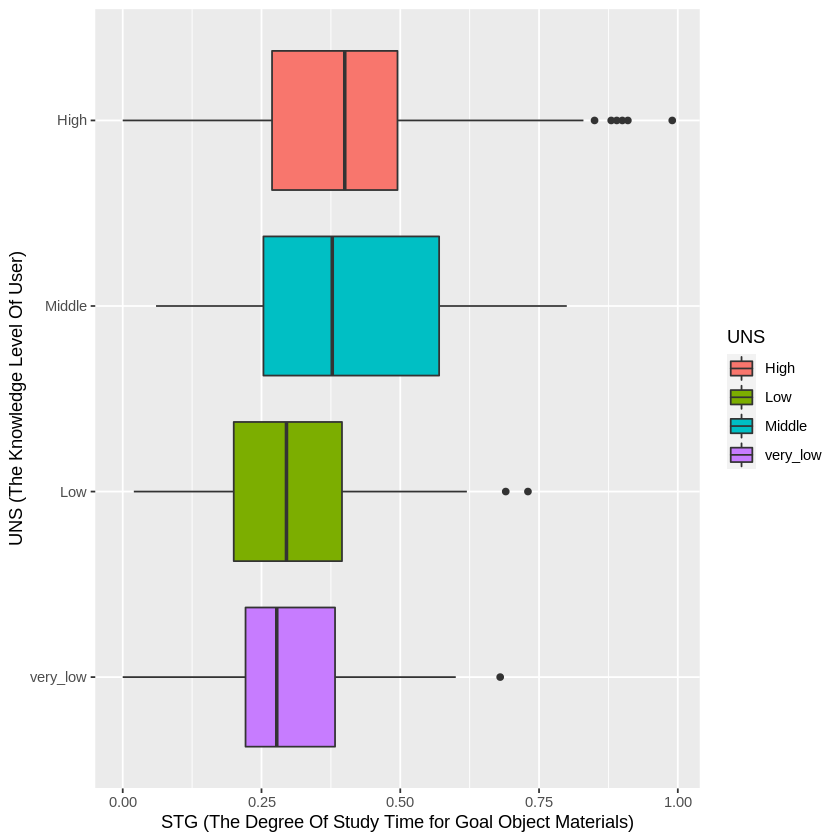

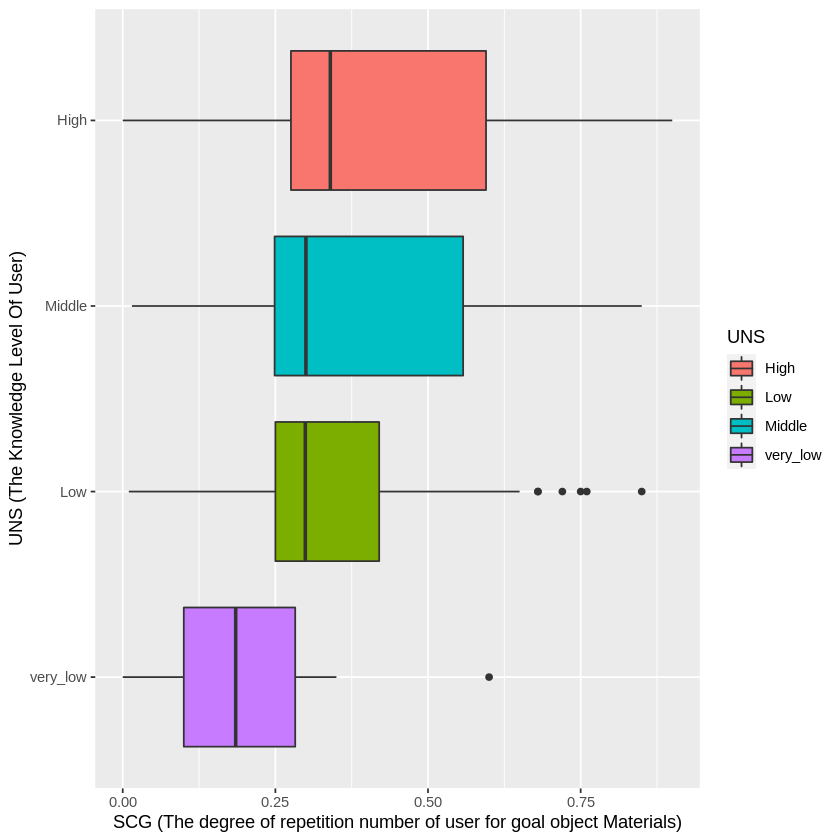

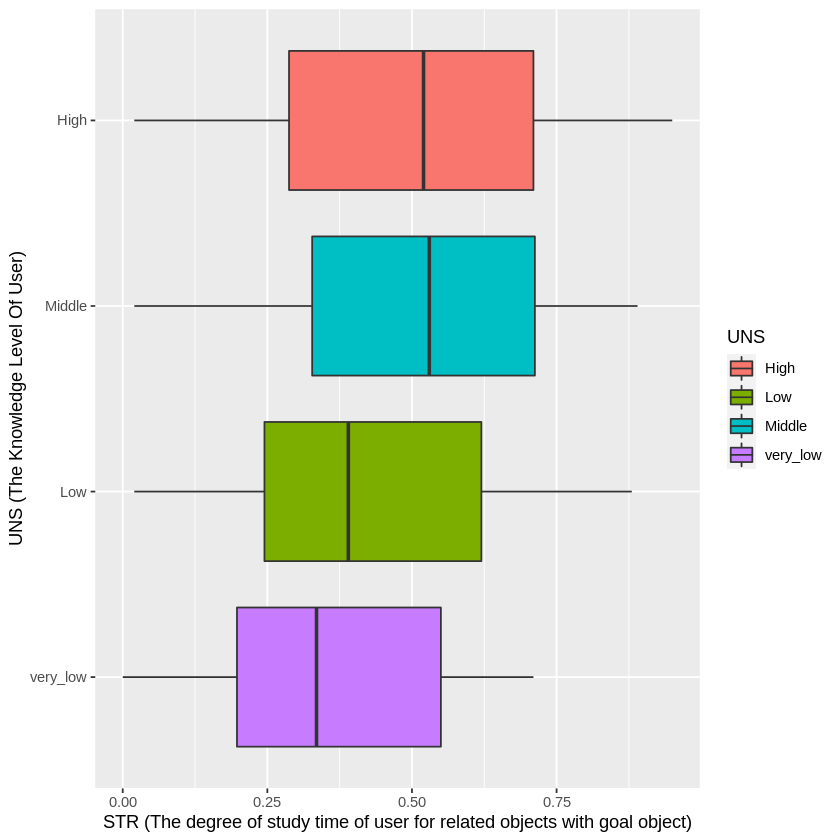

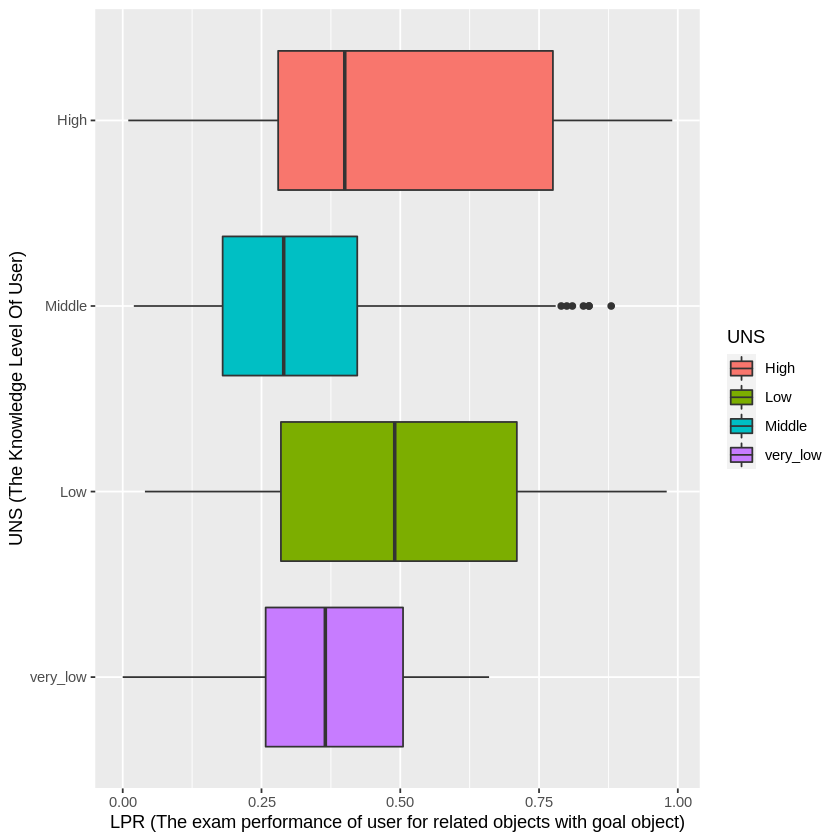

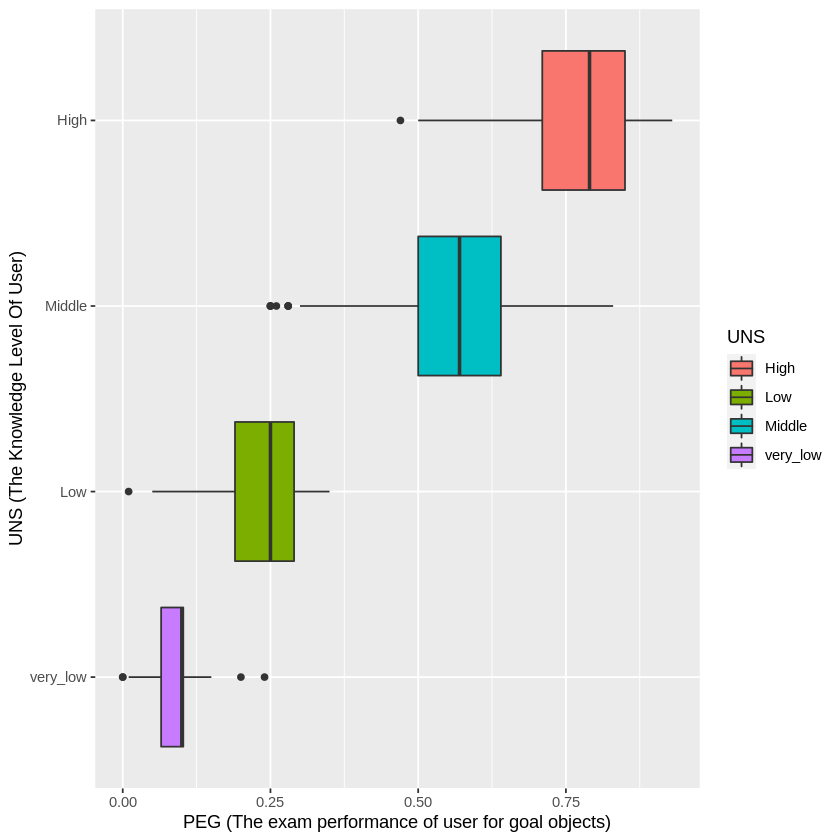

In [7]:
tally
means
pvl1
pvl2
pvl3
pvl4
pvl5